Does the map output include depth of truncated water columns?

 - NetNode_z does not have the quantized depths
 - FlowElem_zcc does not have the quantized depths
 - FlowElem_bl does not have the quantized depths
 - waterdepth is not quantized
 - DWAQ output, with volumes and planform area, *does* include stairstepping.

This is all from a run with mdu['numerics','Keepzlayeringatbed']=1
which I think produces stairstepped beds.

Based on the depths in DWAQ output compared to incoming FlowElem_bl values,
DFM is extending layers out to the next deeper layer elevation. 
(FlowElem_bcc showed some missing data on the NW corner, unclear why).



In [101]:
import xarray as xr
import numpy as np
from stompy.grid import unstructured_grid
from stompy.plot import plot_utils
from stompy import utils
from stompy.model.delft import dfm_grid
import stompy.model.delft.waq_scenario as waq
import stompy.model.delft.io as dio
from stompy.spatial import proj_utils
utm2ll=proj_utils.mapper('EPSG:26910','WGS84')
import matplotlib.pyplot as plt
%matplotlib inline

In [229]:
map_ds=xr.open_dataset('runs/short_28/DFM_OUTPUT_short_28/short_28_map.nc')

g=dfm_grid.DFMGrid(map_ds)

In [ ]:
fig,ax=plt.subplots()

g.plot_edges(lw=0.5,color='k')
ncoll=g.plot_nodes(values=map_ds.NetNode_z.values )
cbar=plot_utils.cbar(ncoll)

In [3]:
hydro=waq.HydroFiles('runs/short_28/DFM_DELWAQ_short_28/short_28.hyd')

hyd_g=hydro.grid()

# This file is truncated, and currently waq won't infer n_seg:
kmx=20
hydro._n_seg=hyd_g.Ncells() * kmx

In [11]:
vols=hydro.volumes(hydro.t_secs[0])

A=hydro.planform_areas()

seg_depth = vols/A.data

In [ ]:
plt.figure(2).clf()
# plt.hist(map_ds.NetNode_z.values,bins=100)
# plt.hist(map_ds.FlowElem_zcc.values,bins=100)
# plt.hist(map_ds.FlowElem_bl.values,bins=100)
# plt.hist(map_ds.waterdepth.isel(time=0).values, bins=100)
plt.hist(seg_depth,bins=100)

In [12]:
#   Verified that (a) I can calculate the right z layer boundaries
#           and (b) depths are extended to the next deeper interface.
#   Add an option to ocean_dfm.py to truncate depths at those interfaces,
#   plus a bit of slop (assuming they are truncated, not extended)
elt_depths = np.zeros( hydro.n_2d_elements, 'f8')

for elt,depth in zip(hydro.seg_to_2d_element,seg_depth):
    elt_depths[elt] += depth

In [19]:
np.unique(np.round(elt_depths,1))

array([    7.6,    11.7,    17.7,    26.1,    38.2,    55.5,    80.2,
         115.4,   165.7,   237.7,   340.4,   487.2,   696.9,   996.4,
        1424.4,  2035.7,  2909. ,  4156.6])

In [27]:
mdu=dio.MDUFile('runs/short_28/short_28.mdu')
eta0=float( mdu['geometry','WaterLevIni'] )

print(np.unique(np.round(elt_depths - eta0,2)))
print(np.round(dio.exp_z_layers(mdu),2))

[    5.99    10.13    16.06    24.52    36.61    53.87    78.54   113.78
   164.13   236.05   338.8    485.58   695.26   994.81  1422.74  2034.07
  2907.39  4155.  ]
[ -4.15500000e+03  -2.90739000e+03  -2.03407000e+03  -1.42274000e+03
  -9.94810000e+02  -6.95260000e+02  -4.85580000e+02  -3.38800000e+02
  -2.36050000e+02  -1.64130000e+02  -1.13780000e+02  -7.85400000e+01
  -5.38700000e+01  -3.66100000e+01  -2.45200000e+01  -1.60600000e+01
  -1.01300000e+01  -5.99000000e+00  -3.08000000e+00  -1.05000000e+00
   3.70000000e-01]


Text(0,0.5,'Element depth')

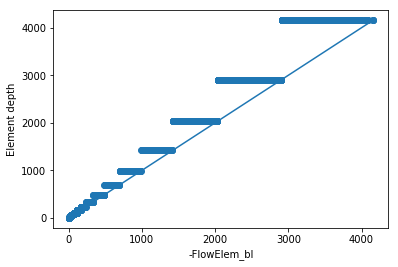

In [34]:
# Verify that depths in the grid are truncated to z layers.
fig,ax=plt.subplots()

mdu_z_layers=dio.exp_z_layers(mdu)

ax.scatter(-map_ds.FlowElem_bl.values, elt_depths-eta0 )
ax.plot(-mdu_z_layers,-mdu_z_layers)
ax.set_xlabel('-FlowElem_bl')
ax.set_ylabel('Element depth')

# This suggest that the edges are padded deeper to the
# next z-layer boundary, not truncated.
# Also, there are some elements which I was expecting to have
# near zero depth, but DWAQ thinks are 4000m deep.

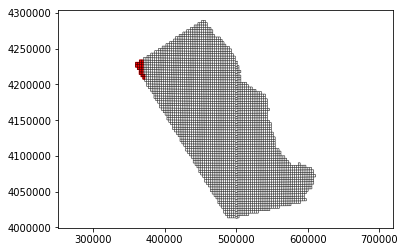

In [35]:
# 20 of these
weird_elts = np.nonzero( (map_ds.FlowElem_zcc.values < 1000) & (elt_depths>3500))[0]
# but they appear to be fine in FlowElem_bl

fig,ax=plt.subplots()
g.plot_edges(color='k',lw=0.5)
g.plot_cells(mask=weird_elts,color='r')

Separately, ocean_dfm.py has been updated to allow for using fluxes from OTPS, and
to include the effect of the truncated bed.  The time series of fluxes was output
to short_28-flux.nc

In [38]:
fluxes=xr.open_dataset('short_28-flux.nc')

In [41]:
fluxes

<xarray.Dataset>
Dimensions:  (time: 5040)
Coordinates:
  * time     (time) datetime64[ns] 2017-06-29 2017-06-29T00:10:00 ...
Data variables:
    result   (time) float64 ...

In [51]:
flux_dt_s=np.median(np.diff(fluxes.time)) / np.timedelta64(1,'s')


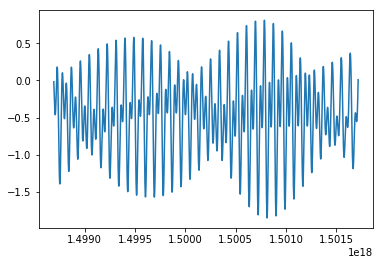

In [61]:
# elif 'hycom' in coastal_source:
from sfb_dfm_utils import hycom, ca_roms

coastal_pad=np.timedelta64(10,'D') # lots of padding to avoid ringing from butterworth
run_start=fluxes.time[0].values
run_stop=fluxes.time[-1].values
coastal_time_range=[run_start-coastal_pad,run_stop+coastal_pad]

hycom_lon_range=[-124.7, -121.7 ]
hycom_lat_range=[36.2, 38.85]

coastal_files=hycom.fetch_range(hycom_lon_range,hycom_lat_range,coastal_time_range)

In [62]:
coastal_bc_coords=[ [450980., 4291405.], # northern
                    [595426., 4037083.] ] # southern
if coastal_bc_coords is not None:
    candidate_nodes=g.select_nodes_boundary_segment(coastal_bc_coords)
    candidates=[ g.nodes_to_edge( [a,b] )
                 for a,b in zip(candidate_nodes[:-1],
                                candidate_nodes[1:]) ]
    candidates=np.array(candidates)
else:
    candidates=None # !? danger will robinson.

ca_roms.annotate_grid_from_data(g,coastal_files,candidate_edges=candidates)

boundary_edges=np.nonzero( g.edges['src_idx_out'][:,0] >= 0 )[0]


INFO:root:/opt/data/delft/cache/hycom/2017061900--124.70_-121.70_36.20_38.85.nc
INFO:root:Will assume wet-cells in first time step true for eternity
INFO:ca_roms:0/7676


In [74]:
# May move more of this to sfb_dfm_utils in the future                                                                                                                               
from stompy.model import otps
Otps=otps.otps_model.OTPS('/home/rusty/src/otps/OTPS2', # Locations of the OTPS software                                                                                             
                          '/opt/data/otps') # location of the data
                                                                                                                                                    
if 0: # more direct way to get locations                                                                                                                                              
    edge_xy= g.edges_center()[boundary_edges]
    boundary_out_ll=utm2ll(edge_xy)
else: 
    # the way that ocean_dfm gets the locations, since it came from
    # code that was trying to match ROMS more exactly.
    src=xr.open_dataset(coastal_files[0])
    # xy for boundary edges:
    boundary_out_lats=src.lat.values[ g.edges['src_idx_out'][boundary_edges,0] ]
    boundary_out_lons=(src.lon.values[ g.edges['src_idx_out'][boundary_edges,1] ] + 180) % 360 - 180
    boundary_out_ll=np.c_[boundary_out_lons,boundary_out_lats]

z_harmonics = Otps.extract_HC( boundary_out_ll )                                                                                                                                     

In [77]:
pad=np.timedelta64(2,'D')                                                                                                                                                            
otps_times=fluxes.time.values
otps_water_level=otps.reconstruct(z_harmonics,otps_times)                                                                                                                            

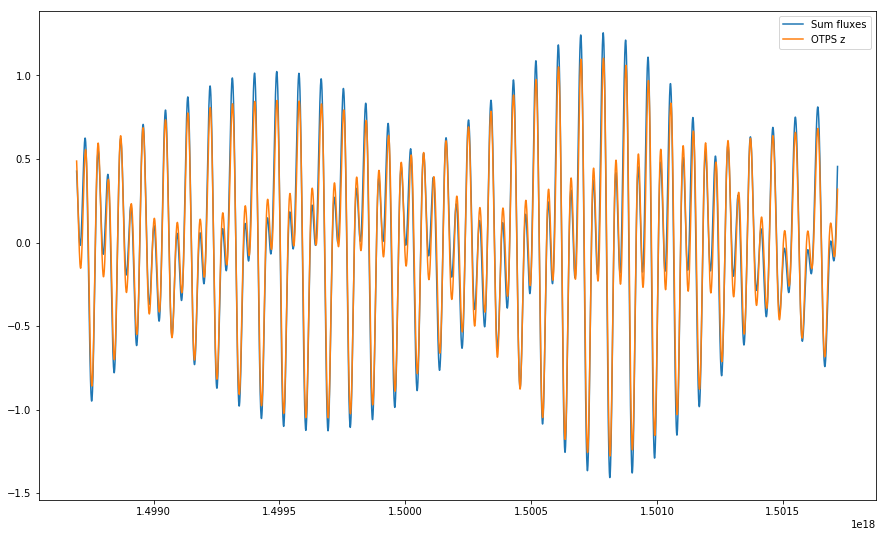

In [78]:
fig,ax=plt.subplots(figsize=(15,9))

# instantaneous:
# ax.plot(fluxes.time,fluxes.result)

prism=np.cumsum(fluxes.result.values) * flux_dt_s
domain_area=g.cells_area().sum()
flux_z=prism/domain_area 
ax.plot(fluxes.time,flux_z - flux_z.mean(),label='Sum fluxes')
otps_z=otps_water_level.result.mean(dim='site')
ax.plot(otps_water_level.time,
        otps_z - otps_z.mean() ,label='OTPS z')
ax.legend()

otps_z ~ 0.8967 flux_z  (inv=1.1152)


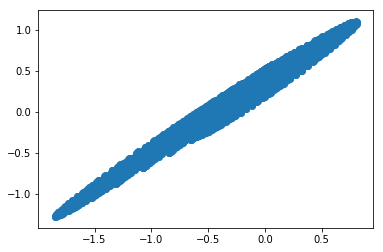

In [87]:
fig,ax=plt.subplots()
ax.scatter(flux_z, otps_z)
mb=np.polyfit(flux_z,otps_z,1)
print("otps_z ~ %.4f flux_z  (inv=%.4f)"%(mb[0],1/mb[0]))

In [230]:
map_ds.close()
map_ds=xr.open_dataset('runs/short_28/DFM_OUTPUT_short_28/short_28_map.nc')

In [231]:
elt=100
elt_xy = np.array( [map_ds.FlowElem_xcc.values[elt],
                    map_ds.FlowElem_ycc.values[elt]])
elt_ll=utm2ll(elt_xy)

z_elt_harmonics = Otps.extract_HC( [elt_ll] )
z_elt=otps.reconstruct(z_elt_harmonics,otps_times)       
                                              

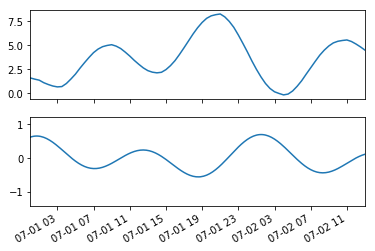

In [232]:
fig,(ax,ax_z)=plt.subplots(2,1,sharex=True)

map_dns=utils.to_datetime(map_ds.time.values)

ax.plot(map_dns,map_ds.s1.isel(nFlowElem=elt))

ax_z.plot(utils.to_datetime(otps_times),z_elt.result.isel(site=0))
ax.axis(xmin=map_dns[0],xmax=map_dns[-1])
fig.autofmt_xdate()

In [233]:
# This is still pretty bad.  Look at the fluxes for a single boundary
# edge, see how we're doing.  This will be OTPS flux/depth, vs. 
# map output unorm.
# ji=0 # deep
ji=200 # just over 1300m deep
j=boundary_edges[ji]

edges_xy= g.edges_center()[boundary_edges]
boundary_out_ll=utm2ll(edges_xy)

edge_xy=edges_xy[ji] 
print("This is small: %s"%(edge_xy - g.edges_center()[j]))

link_xy=np.c_[map_ds.FlowLink_xu.values,map_ds.FlowLink_yu]
dists=utils.dist(edge_xy-link_xy)
link_idx=np.argmin(dists)
print("Matched edge %d to link %d within %.2f m"%(j,link_idx,dists[link_idx]))

unorm=map_ds.unorm.isel(nFlowLink=link_idx)

This is small: [ 0.  0.]
Matched edge 7140 to link 7501 within 0.00 m


In [234]:
# Get the OTPS prediction for all BC edges
u_edge_harmonics = Otps.extract_HC( boundary_out_ll,quant='u' )
v_edge_harmonics = Otps.extract_HC( boundary_out_ll,quant='v' )
# take care of cm/s conversion, too
u_edge=otps.reconstruct(u_edge_harmonics, unorm.time.values) / 100.0
v_edge=otps.reconstruct(v_edge_harmonics, unorm.time.values) / 100.0

In [235]:
edges_norm_in=g.edges['bc_norm_in'][boundary_edges]

otps_inwards = (u_edge.result *edges_norm_in[:,0][:,None] 
                + v_edge.result*edges_norm_in[:,1][:,None])
otps_inward=otps_inwards.isel(site=ji)

ValueError: no field of name bc_norm_in

In [221]:
unorm.time.shape

(496,)

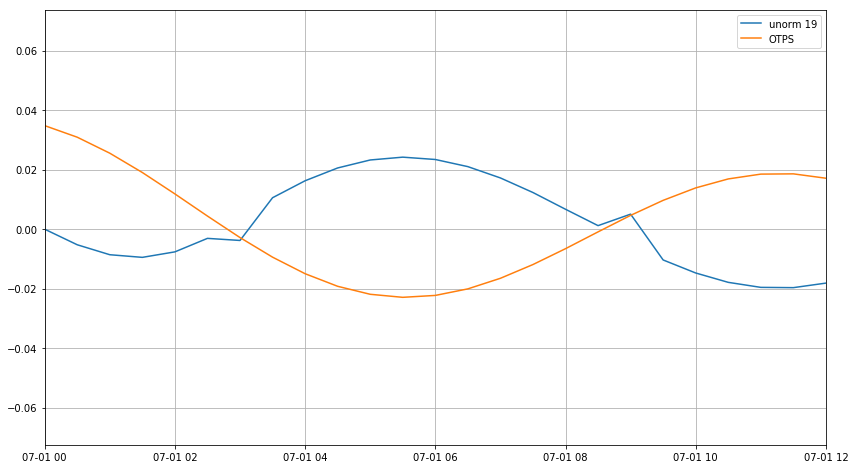

In [222]:
fig,ax=plt.subplots(figsize=(14,8))
for lay in [19]:
    ax.plot(utils.to_datetime(unorm.time.values), 
            (1/0.08786)*map_ds.unorm.isel(nFlowLink=link_idx,laydim=lay),label='unorm %d'%lay)

ax.plot(utils.to_datetime(otps_inward.time.values), otps_inward.values,label='OTPS')
ax.legend()
ax.axis(xmin=map_dns[0],xmax=map_dns[24])
ax.grid(1)

In [223]:
# See how the normals compare in general
xyflip=[]

for ji,j in enumerate(boundary_edges):
    edge_xy=edges_xy[ji] 

    dists=utils.dist(edge_xy-link_xy)
    link_idx=np.argmin(dists)

    unorm=map_ds.unorm.isel(nFlowLink=link_idx,laydim=19)
    otps_inward=otps_inwards.isel(site=ji)
    mb=np.polyfit(otps_inward.values[4:],unorm.values[4:],1)
    xyflip.append( (edge_xy[0],edge_xy[1],mb[0]) )

xyflip=np.array(xyflip)

0.95358100807847179

(350000.0, 380000.0, 4200000.0, 4250000.0)

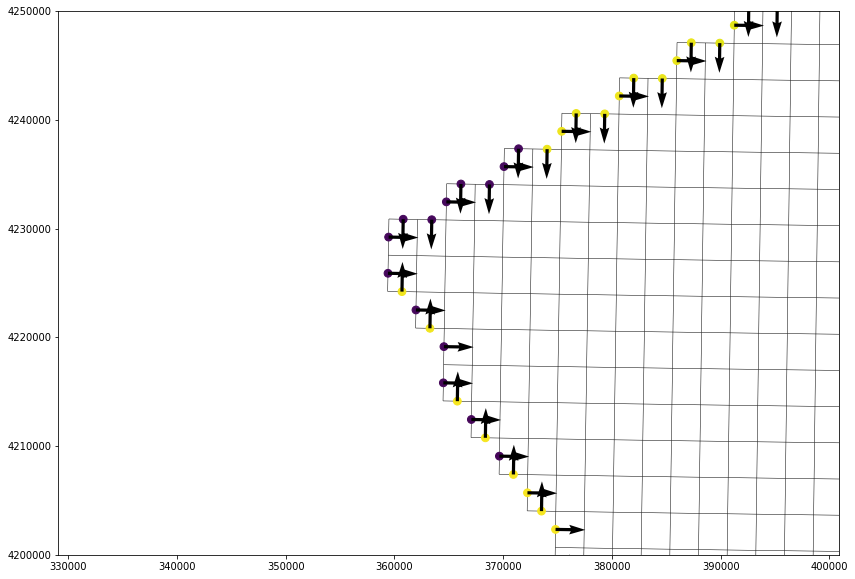

In [228]:
fig,ax=plt.subplots(figsize=(14,10))
scat=ax.scatter(xyflip[:,0],xyflip[:,1],60,xyflip[:,2])
scat.set_clim([-.1,.1])
g.plot_edges(color='k',lw=0.5,zorder=-1)

ax.quiver(edges_xy[:,0],edges_xy[:,1],edges_norm_in[:,0],edges_norm_in[:,1])
ax.axis( xmin=350e3,xmax=380e3,ymin=4.2e6, ymax=4.25e6)

In [123]:
map_ds

<xarray.Dataset>
Dimensions:                      (laydim: 20, nBndLink: 364, nFlowElem: 3747, nFlowElemContourPts: 4, nFlowLink: 7503, nFlowLinkPts: 2, nNetElem: 3747, nNetElemMaxNode: 4, nNetLink: 7676, nNetLinkContourPts: 4, nNetLinkPts: 2, nNetNode: 3930, nmesh2d_EnclosureInstance: 1, nmesh2d_EnclosureParts: 1, nmesh2d_EnclosurePoints: 365, time: 281, wdim: 21)
Coordinates:
    NetNode_x                    (nNetNode) float64 ...
    NetNode_y                    (nNetNode) float64 ...
    FlowElem_xcc                 (nFlowElem) float64 3.607e+05 3.608e+05 ...
    FlowElem_ycc                 (nFlowElem) float64 4.226e+06 4.229e+06 ...
    FlowLink_xu                  (nFlowLink) float64 ...
    FlowLink_yu                  (nFlowLink) float64 ...
  * time                         (time) datetime64[ns] 2017-07-01 ...
Dimensions without coordinates: laydim, nBndLink, nFlowElem, nFlowElemContourPts, nFlowLink, nFlowLinkPts, nNetElem, nNetElemMaxNode, nNetLink, nNetLinkContourPts, nNetL